# Finding Elements with Selectors

Natural PDF uses CSS-like selectors to find elements (text, lines, images, etc.) within a PDF page or document. This guide demonstrates how to use these selectors effectively.

## Setup

Let's load a sample PDF to work with. We'll use `01-practice.pdf` which has various elements.

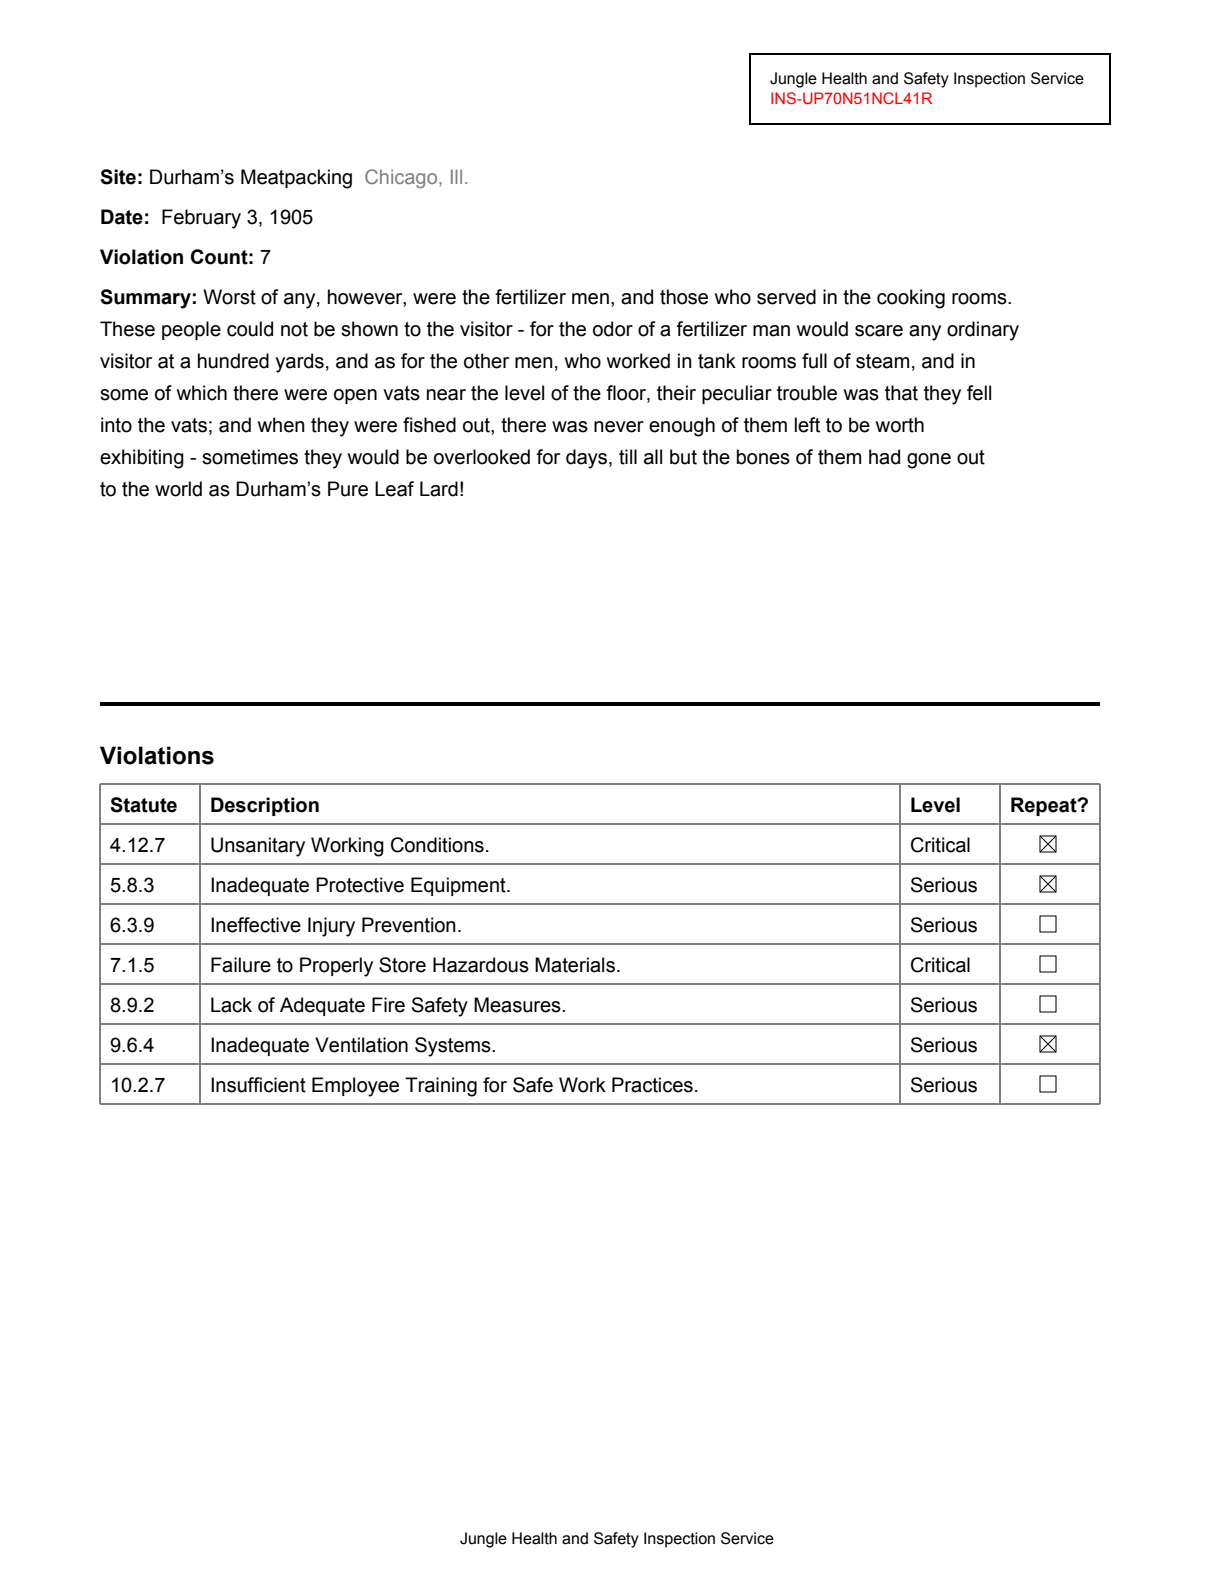

In [1]:
from natural_pdf import PDF

# Load the PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Select the first page
page = pdf.pages[0]

# Display the page
page.show()

## Basic Element Finding

The core methods are `find()` (returns the first match) and `find_all()` (returns all matches as an `ElementCollection`).

The basic selector structure is `element_type[attribute_filter]:pseudo_class`.

### Finding Text by Content

In [2]:
# Find the first text element containing "Summary"
summary_text = page.find('text:contains("Summary")')
summary_text

<TextElement text='Summary: ' font='Helvetica' size=10.0, style=['bold'] bbox=(50.0, 144.07000000000005, 101.68, 154.07000000000005)>

In [3]:
# Find all text elements containing "Inadequate"
contains_inadequate = page.find_all('text:contains("Inadequate")')
len(contains_inadequate)

2

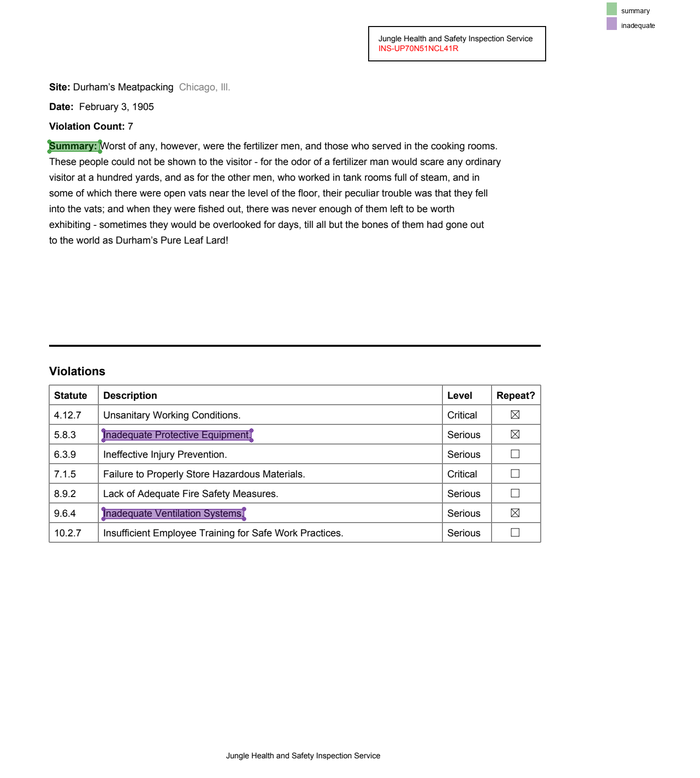

In [4]:
summary_text.highlight(label='summary')
contains_inadequate.highlight(label="inadequate")
page.to_image(width=700)

## Selecting by Element Type

You can select specific types of elements found in PDFs.

In [5]:
# Find all text elements
all_text = page.find_all('text')
len(all_text)

44

In [6]:
# Find all rectangle elements
all_rects = page.find_all('rect')
len(all_rects)

8

In [7]:
# Find all line elements
all_lines = page.find_all('line')
len(all_lines)

21

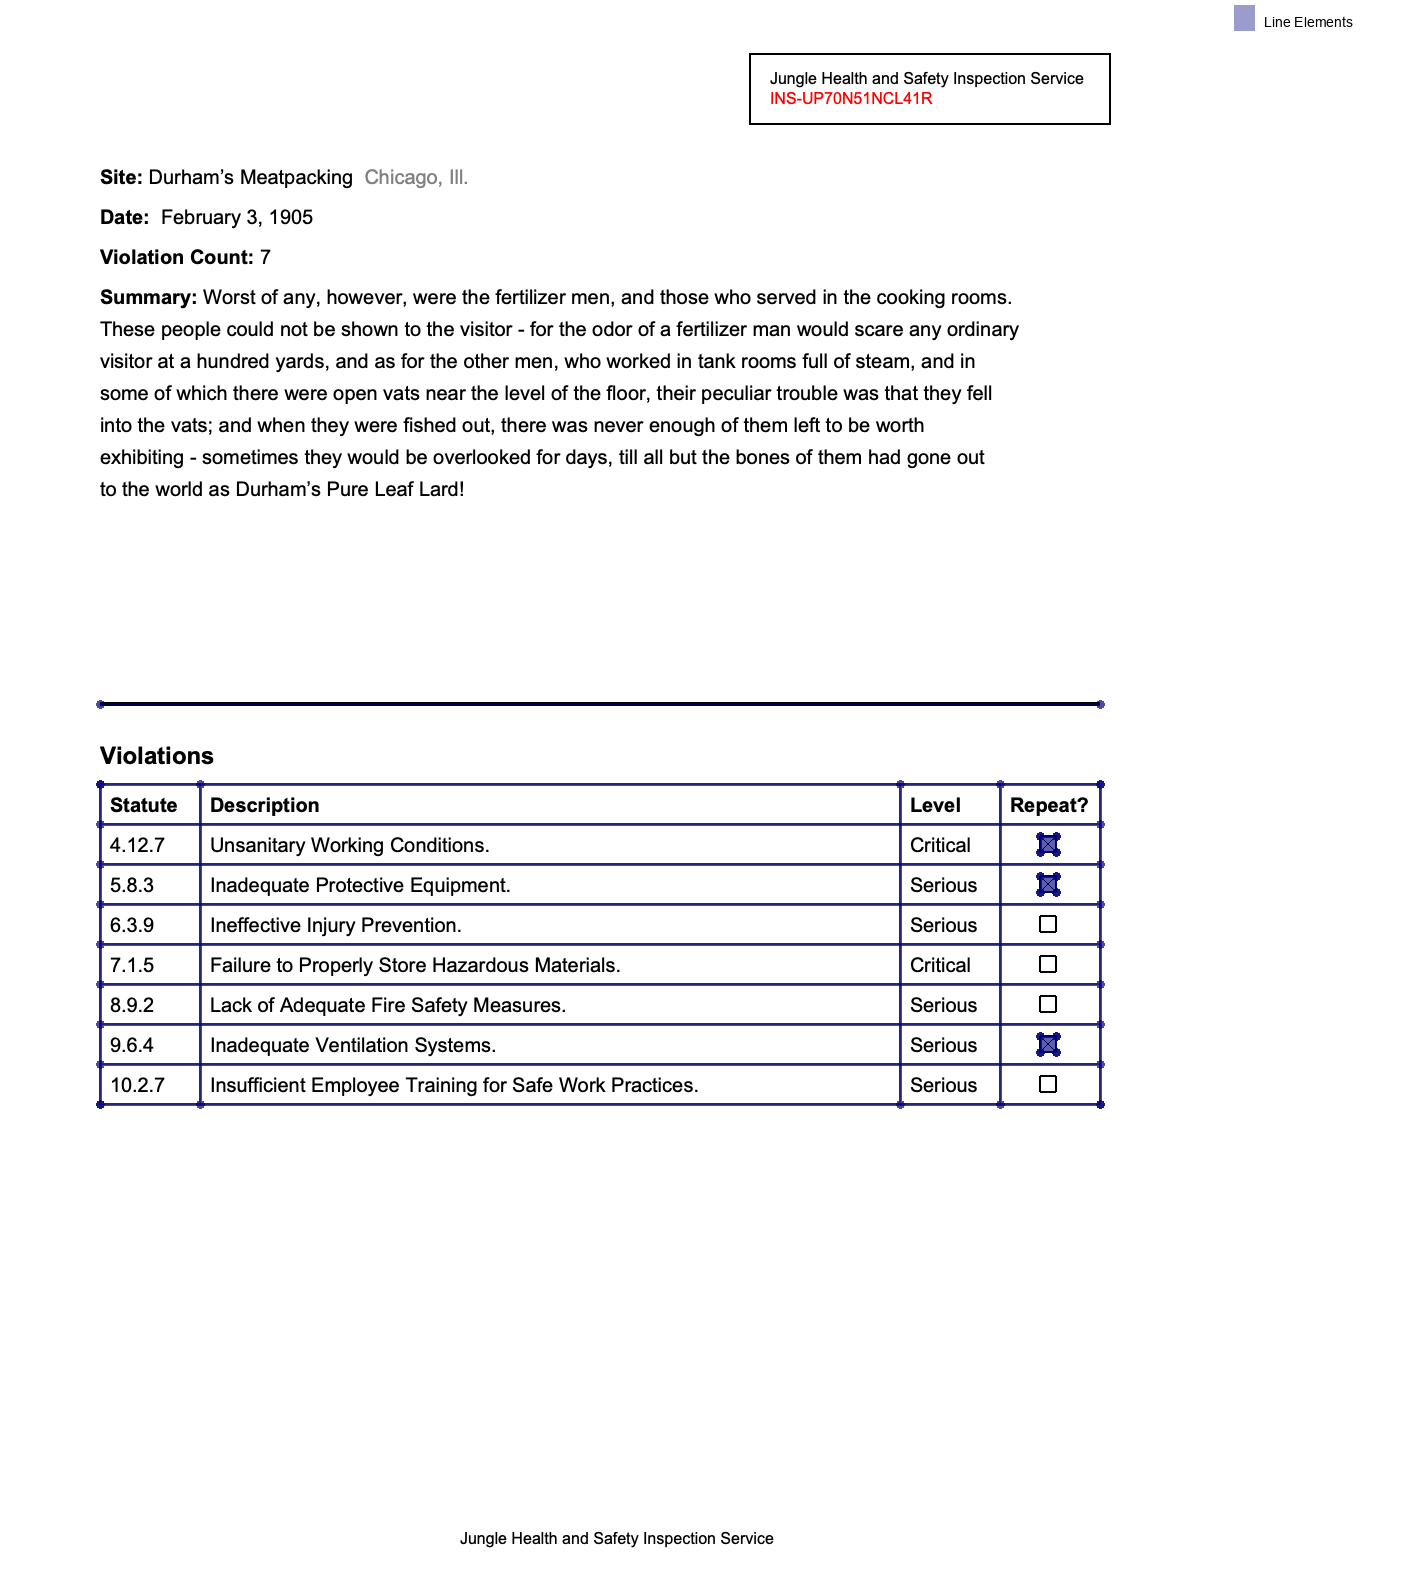

In [8]:
page.find_all('line').show()

## Filtering by Attributes

Use square brackets `[]` to filter elements by their properties (attributes).

### Common Attributes & Operators

| Attribute     | Example Usage          | Operators | Notes |
|---------------|------------------------|-----------|-------|
| `size` (text) | `text[size>=12]`       | `>`, `<`, `>=`, `<=` | Font size in points |
| `fontname`    | `text[fontname*=Bold]` | `=`, `*=`  | `*=` for contains substring |
| `color` (text)| `text[color~=red]`     | `~=`      | Approx. match (name, rgb, hex) |
| `width` (line)| `line[width>1]`        | `>`, `<`, `>=`, `<=` | Line thickness |
| `source`      | `text[source=ocr]`     | `=`       | `pdf`, `ocr`, `detected` |
| `type` (region)| `region[type=table]`  | `=`       | Layout analysis region type |

In [9]:
# Find large text (size >= 11 points)
page.find_all('text[size>=11]')

<ElementCollection[TextElement](count=1)>

In [10]:
# Find text with 'Helvetica' in the font name
page.find_all('text[fontname*=Helvetica]')

<ElementCollection[TextElement](count=44)>

In [11]:
# Find red text (using approximate color match)
# This PDF has text with color (0.8, 0.0, 0.0)
red_text = page.find_all('text[color~=red]')

2025-05-06T15:29:20.997374Z [warning  ] Unsupported operator '~=' encountered during filter building for attribute 'color' lineno=445 module=natural_pdf.selectors.parser


[2025-05-06 11:29:20,997] [ WARNING] parser.py:445 - Unsupported operator '~=' encountered during filter building for attribute 'color'


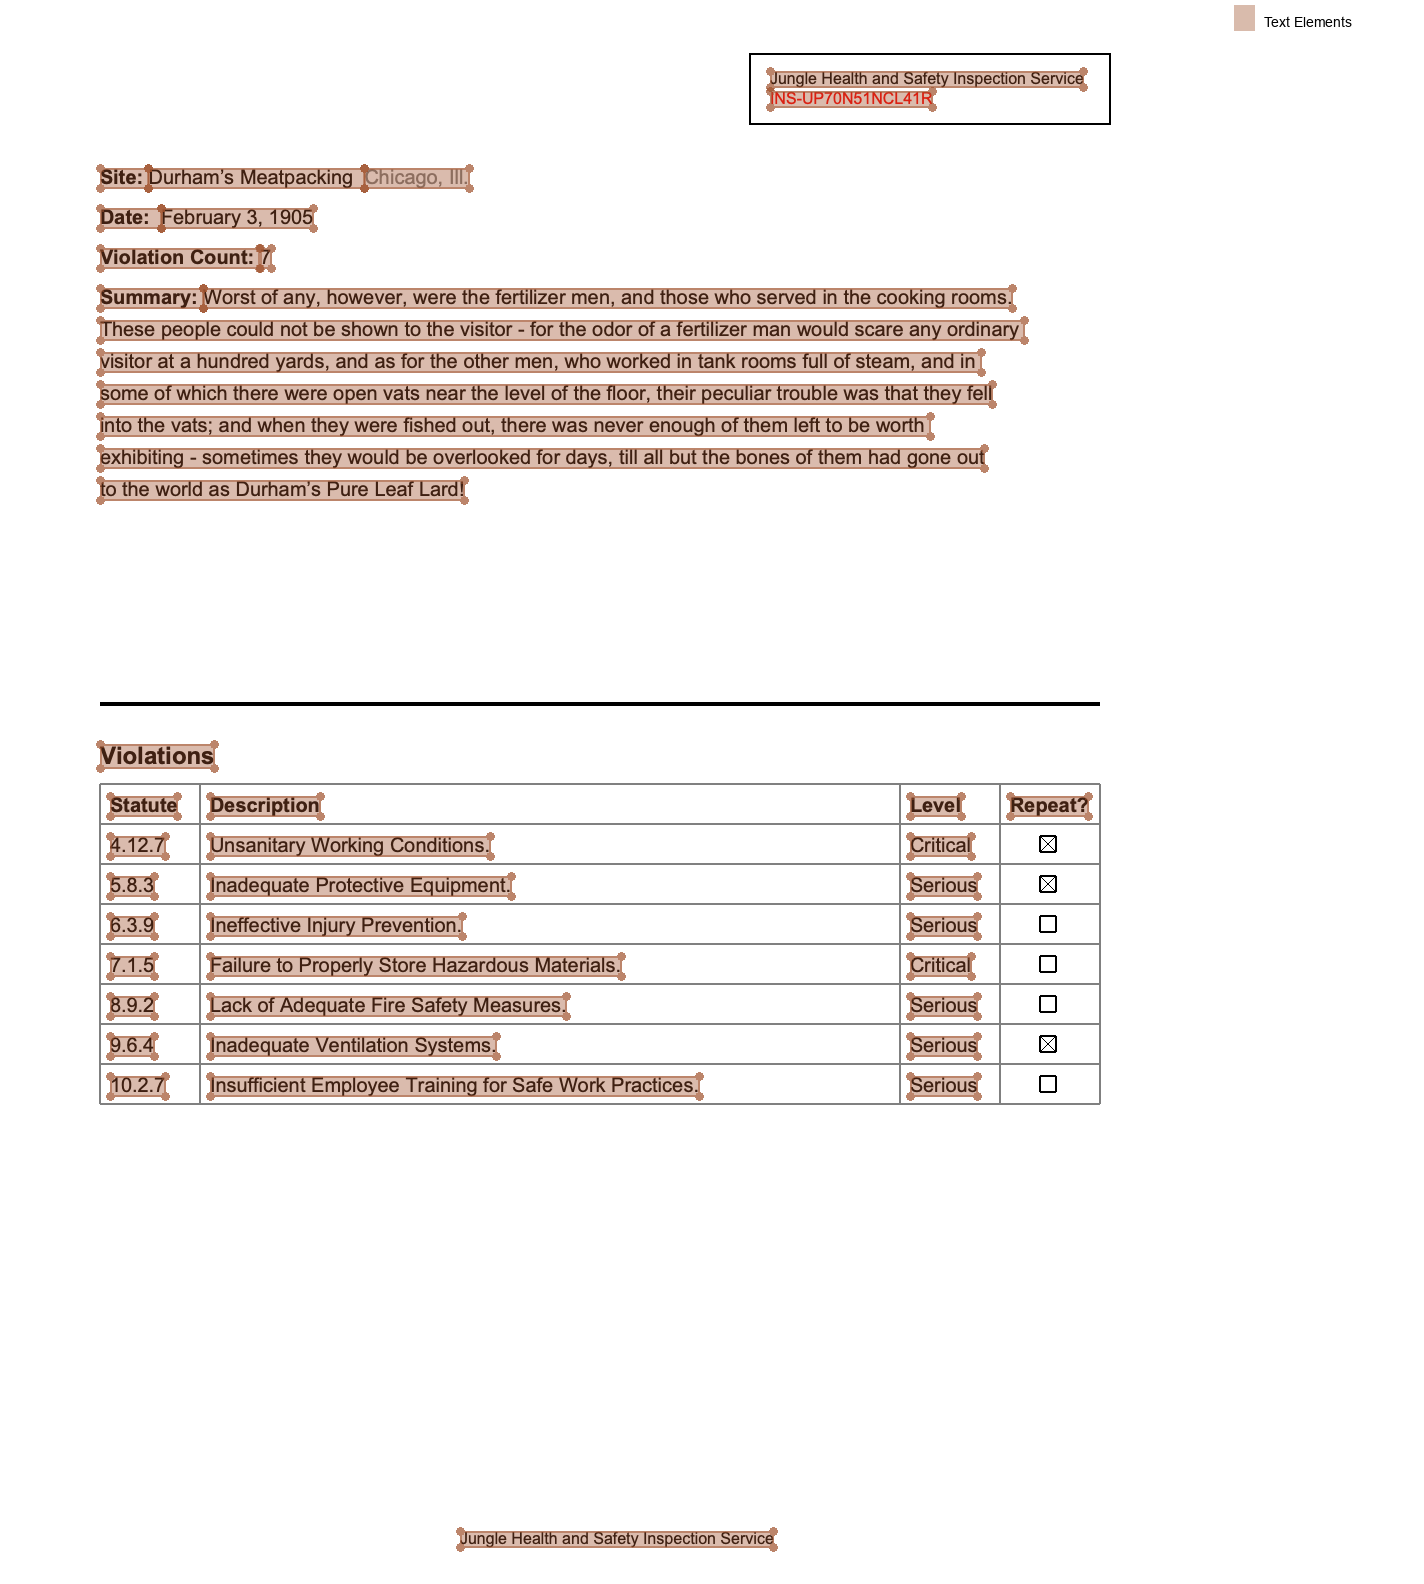

In [12]:
# Highlight the red text (ignoring existing highlights)
red_text.show()

In [13]:
# Find thick lines (width >= 2)
page.find_all('line[width>=2]')

<ElementCollection[LineElement](count=1)>

## Using Pseudo-Classes

Use colons `:` for special conditions (pseudo-classes).

### Common Pseudo-Classes

| Pseudo-Class          | Example Usage                           | Notes |
|-----------------------|-----------------------------------------|-------|
| `:contains('text')` | `text:contains('Report')`             | Finds elements containing specific text |
| `:bold`               | `text:bold`                             | Finds text heuristically identified as bold |
| `:italic`             | `text:italic`                           | Finds text heuristically identified as italic |
| `:below(selector)`    | `text:below('line[width>=2]')`         | Finds elements physically below the reference element |
| `:above(selector)`    | `text:above('text:contains("Summary")')`| Finds elements physically above the reference element |
| `:left-of(selector)`  | `line:left-of('rect')`                 | Finds elements physically left of the reference element |
| `:right-of(selector)` | `text:right-of('rect')`                | Finds elements physically right of the reference element |
| `:near(selector)`     | `text:near('image')`                   | Finds elements physically near the reference element |

*Note: Spatial pseudo-classes like `:below`, `:above` identify elements based on bounding box positions relative to the **first** element matched by the inner selector.*

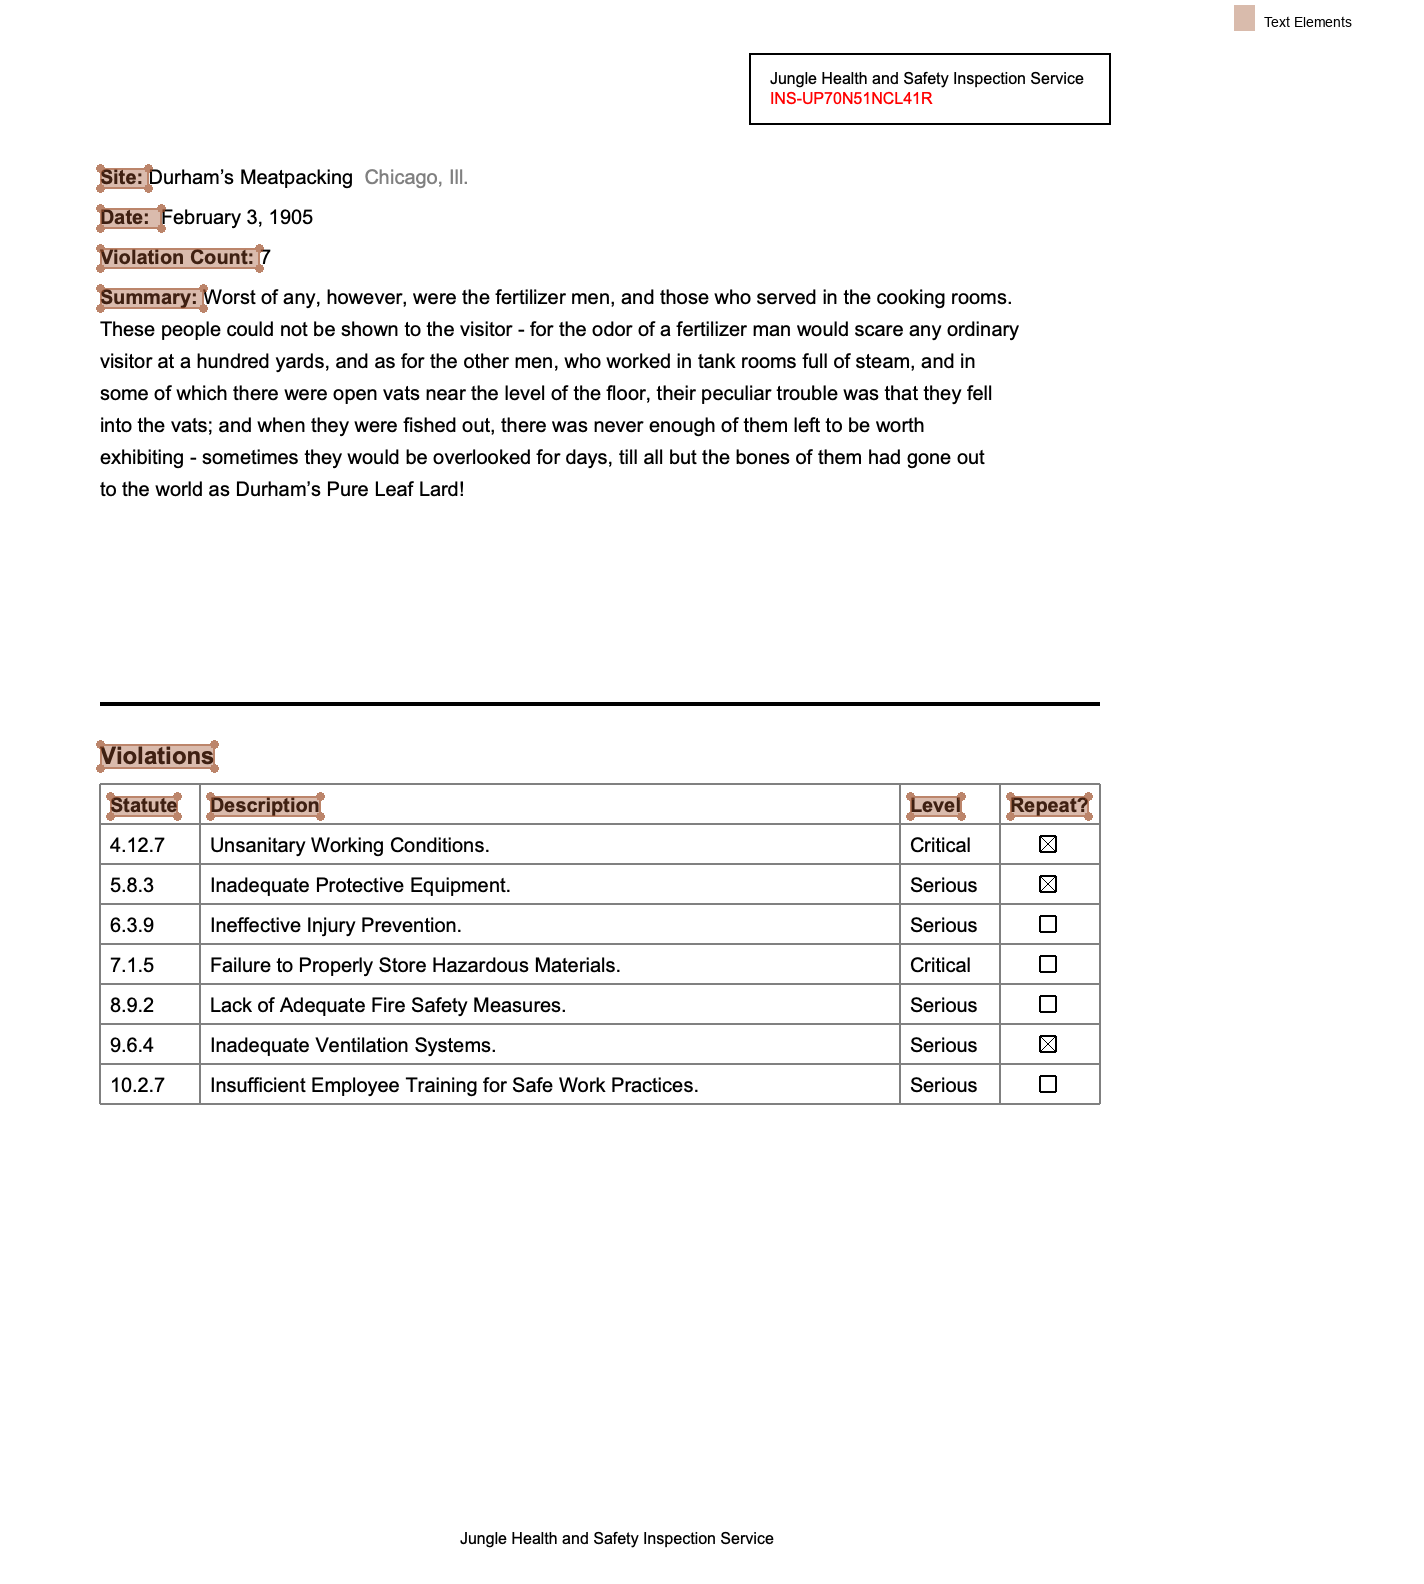

In [14]:
# Find bold text
page.find_all('text:bold').show()

In [15]:
# Combine attribute and pseudo-class: bold text size >= 11
page.find_all('text[size>=11]:bold')

<ElementCollection[TextElement](count=1)>

### Negation Pseudo-class (`:not()`)

You can exclude elements that match a certain selector using the `:not()` pseudo-class. It takes another simple selector as its argument.

In [16]:
# Find all text elements that are NOT bold
non_bold_text = page.find_all('text:not(:bold)')

# Find all elements that are NOT regions of type 'table'
not_tables = page.find_all(':not(region[type=table])')

# Find text elements that do not contain "Total" (case-insensitive)
relevant_text = page.find_all('text:not(:contains("Total"))', case=False)

# Find text elements that are not empty
non_empty_text = page.find_all('text:not(:empty)')

**Note:** The selector inside `:not()` follows the same rules as regular selectors but currently does not support combinators (like `>`, `+`, `~`, or descendant space) within `:not()`. You can nest basic type, attribute, and other pseudo-class selectors.

### Spatial Pseudo-Classes Examples

In [17]:
# Find the thick horizontal line first
ref_line = page.find('line[width>=2]')

# Find text elements strictly above that line
text_above_line = page.find_all('text:above("line[width>=2]")')
text_above_line

<ElementCollection[TextElement](count=17)>

## Advanced Text Searching Options

Pass options to `find()` or `find_all()` for more control over text matching.

In [18]:
# Case-insensitive search for "summary"
page.find_all('text:contains("summary")', case=False)

<ElementCollection[TextElement](count=1)>

In [19]:
# Regular expression search for the inspection ID (e.g., INS-XXX...)
# The ID is in the red text we found earlier
page.find_all('text:contains("INS-\\w+")', regex=True)

<ElementCollection[TextElement](count=1)>

In [20]:
# Combine regex and case-insensitivity
page.find_all('text:contains("jungle health")', regex=True, case=False)

<ElementCollection[TextElement](count=2)>

## Working with ElementCollections

`find_all()` returns an `ElementCollection`, which is like a list but with extra PDF-specific methods.

In [21]:
# Get all headings (using a selector for large, bold text)
headings = page.find_all('text[size>=11]:bold')
headings

<ElementCollection[TextElement](count=1)>

In [22]:
# Get the first and last heading in reading order
first = headings.first
last = headings.last
(first, last)

(<TextElement text='Violations' font='Helvetica' size=12.0, style=['bold'] bbox=(50.0, 372.484, 107.348, 384.484)>,
 <TextElement text='Violations' font='Helvetica' size=12.0, style=['bold'] bbox=(50.0, 372.484, 107.348, 384.484)>)

In [23]:
# Get the physically highest/lowest element in the collection
highest = headings.highest()
lowest = headings.lowest()
(highest, lowest)

(<TextElement text='Violations' font='Helvetica' size=12.0, style=['bold'] bbox=(50.0, 372.484, 107.348, 384.484)>,
 <TextElement text='Violations' font='Helvetica' size=12.0, style=['bold'] bbox=(50.0, 372.484, 107.348, 384.484)>)

In [24]:
# Filter the collection further: headings containing "Service"
service_headings = headings.filter(lambda heading: 'Service' in heading.extract_text())

In [25]:
# Extract text from all elements in the collection
headings.extract_text()

'Violations'

*Remember: `.highest()`, `.lowest()`, `.leftmost()`, `.rightmost()` raise errors if the collection spans multiple pages.*

## Font Variants

Sometimes PDFs use font variants (prefixes like `AAAAAB+`) which can be useful for selection.

In [26]:
# Find text elements with a specific font variant prefix (if any exist)
# This example PDF doesn't use variants, but the selector works like this:
page.find_all('text[font-variant=AAAAAB]')

<ElementCollection[Mixed](count=0)>

## Next Steps

Now that you can find elements, explore:

- [Text Extraction](../text-extraction/index.ipynb): Get text content from found elements.
- [Spatial Navigation](../pdf-navigation/index.ipynb): Use found elements as anchors to navigate (`.above()`, `.below()`, etc.).
- [Working with Regions](../regions/index.ipynb): Define areas based on found elements.
- [Visual Debugging](../visual-debugging/index.ipynb): Techniques for highlighting and visualizing elements.